# Sniffer Classifer Predictor
Use this notebook to run predictions with the sniffer classifier

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from keras.metrics import BinaryAccuracy
import seaborn as sns

## Load the model

In [4]:
model_name="binary_classification_model_v_1_4"
model_path=os.getcwd()+ os.sep+"models"+os.sep+model_name

In [5]:
model = tf.keras.models.load_model(model_path+os.sep+"model")
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 10, 10, 64)     

## Local Variables
Use these variables to change the prediction parameters for your CNN.
- `dataset_path`: directory containing the unzipped imagery
- `img_shape` : shape (width , height) your imagery will be resized to. These are inputs into the model. This must be the same size as the size you trained your model on.

In [7]:
dataset_path=os.getcwd()+os.sep+"test_images"
# csv_name="mapped_test_dataset.csv"
csv_name="test_dataset.csv"
csv_path=os.getcwd()+os.sep+csv_name
img_shape=(100, 100)

In [8]:
def pre_process_img(image,img_shape:tuple)->list:
    """returns np.array resized to (1,img_shape,3)"""
    img=image.resize(img_shape,Image.ANTIALIAS)
    imgArray = np.asarray(img)
    imgArray=imgArray.reshape((1,)+img_shape+(3,))# Create batch axis
    return imgArray

In [9]:
def binary_encode_labels(df:'pandas.core.frame.DataFrame',labels=["bad","good"]):
    """ Returns the modified dataframe with the labels encoded into binary (0 or 1)"""
    mapping = {}
    for x in range(len(labels)):
        mapping[labels[x]] = x
    # outputs {'bad': 0, 'good': 1}
    # Replace each label in sorted with corresponding one hot encoded label
    for x in range(len(df['Sorted'])):
        df['Sorted'][x] = mapping[df['Sorted'][x]]
    return df

In [10]:
def read_labeled_df(csv_path:str):
    """Returns a cleaned dataframe with the labels binary encoded.
    Use this function when you have a dataframe with correct labels
    you want to compare the model against
    """
    # Read in the labeled_df that the model has never seen before
    df=pd.read_csv(csv_path)
    if "index" in df.columns:
        print("Dropping column index")
        df.drop(['index'],axis=1,inplace=True)
    if "Unnamed: 0"in df.columns:
        print("Dropping column Unnamed: 0")
        df.drop(['Unnamed: 0'],axis=1,inplace=True)
    # one hot encode the labels in the "sorted" if they aren't already
    if df['Sorted'].dtypes !='int64':
        df=binary_encode_labels(df)
    return df

In [11]:
def create_prediction_ready_data(dataset_path:str,img_shape:tuple):
    """returns a numpy array of the shape (number_images,img_shape,3)"""
    images=[]
    for image in os.listdir(dataset_path):
        img=Image.open(dataset_path+os.sep+image)
        img_array=pre_process_img(img,img_shape)
        images.append(img_array)
    data=np.vstack(images)
    return data

In [12]:
def get_predictions(data:np.array):
    """Returns a numpy array of the predicted labels"""
    predictions=model.predict(data)
    return predictions

In [15]:
df=read_labeled_df(csv_path)
labels=df["Sorted"]
labels=labels.astype('uint8')
labels.value_counts()

Dropping column index


1    110
0     69
Name: Sorted, dtype: int64

In [16]:
data=create_prediction_ready_data(dataset_path,img_shape)
predictions=model.predict(data)

In [37]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
# predictions

In [19]:
m=BinaryAccuracy()
m.update_state(labels,predictions)
print(m.result().numpy())

0.7094972


## Create a Confusion Matrix

In [26]:
# Read the correct labels from the dataframe
df=read_labeled_df(csv_path)
labels=df["Sorted"]
labels=labels.astype('uint8')
# Print the counts of each label (good:1)(bad:0)
labels.value_counts()

Dropping column index


1    110
0     69
Name: Sorted, dtype: int64

[[68  1]
 [51 59]]


Text(0.5, 24.0, 'Predicted')

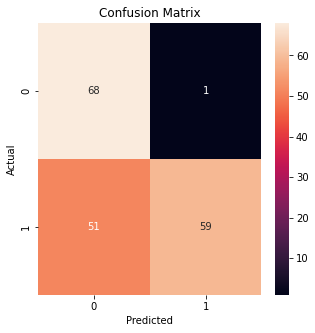

In [28]:
threshold=0.5
y_pred = (predictions > threshold).astype('float')
cm=confusion_matrix(labels,y_pred)
print(cm)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,fmt='g')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

## Predict on a Single Image
---

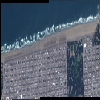

In [34]:
image_path=r"C:\Users\Sharon\Downloads\ob-20220412T220737Z-001\ob"+os.sep+"2017-09-25-18-52-27_L8_rgbr.jpg"
# image_path=r"C:\Users\Sharon\Downloads\duck-20220412T220723Z-001\duck\2015-06-23-15-40-23_L8_rgbr.jpg"

img = keras.preprocessing.image.load_img(
    image_path, target_size=(100,100))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img

In [35]:
prediction=model.predict(np.array(img_array)).flatten()
print(prediction)
threshold=0.5
y_pred = (prediction > threshold).astype('uint8')
print(y_pred)
reverse_mapping={0:"bad",1:"good"}
label=reverse_mapping[y_pred[0]]
label

[0.]
[0]


'bad'